In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import json
import glob
import wandb
import pandas as pd
import seaborn as sns
from autoseg.config import read_config
from autoseg.utils import get_artifact_base_path
from pathlib import Path

In [2]:
def get_vals_for_metric(metric, files):
  xs = []
  vals = []
  for f in sorted(files, key=lambda x: int(x.split("/")[-2].split("-")[1])):
    xs.append(int(f.split("/")[-2].split("-")[1]))
    results = json.load(open(f))
    vals.append(results["best_edits"][metric])
    #vals.append(results["best_nvi"][metric])
  return xs, vals

def get_metrics_for_model(config):
  config = read_config("autoseg/user_configs/anton/" + config)
  results = []
  for dataset in config["evaluation"]["datasets"]:
    path = Path(get_artifact_base_path(config)) / Path(config["evaluation"]["results_dir"])
    path = path.absolute().as_posix()
    files = glob.glob(path + "/step-*/" + dataset["output"])
    for f in files:
      if "step-0" in f:
        files.remove(f)
    print("files", files)

    xs = get_vals_for_metric("voi_sum", files)[0]
    _, merges = get_vals_for_metric("total_merges_needed_to_fix_splits", files)
    _, splits = get_vals_for_metric("total_splits_needed_to_fix_merges", files)
    skel_mods = np.array(merges) + np.array(splits)
    xs = np.array(xs)

    voi_sum = np.array(get_vals_for_metric("voi_sum", files)[1])
    nvi_sum = np.array(get_vals_for_metric("nvi_sum", files)[1])
    path_length = get_vals_for_metric("total path length", files)[1]
    results.append({
      "dataset": [dataset["name"] for _ in range(len(xs))],
      "checkpoints": xs,
      "merges": merges,
      "splits": splits,
      "skel_mods": skel_mods,
      "num_segments": get_vals_for_metric("number_of_segments", files)[1],
      "skel_splits": get_vals_for_metric("total_splits_needed_to_fix_merges", files)[1],
      "skel_merges": get_vals_for_metric("total_merges_needed_to_fix_splits", files)[1],
      "avg_skel_merges": get_vals_for_metric("average_merges_needed_to_fix_splits", files)[1],
      "avg_skel_splits": get_vals_for_metric("average_splits_needed_to_fix_merges", files)[1],
      "voi_sum": voi_sum,
      "voi_merge": get_vals_for_metric("voi_merge", files)[1],
      "voi_split": get_vals_for_metric("voi_split", files)[1],
      "nvi_sum": nvi_sum,
      "nvi_merge": get_vals_for_metric("nvi_merge", files)[1],
      "nvi_split": get_vals_for_metric("nvi_split", files)[1],
      "total_path_length": path_length,
      "threshold": get_vals_for_metric("threshold", files)[1],
    })
  return results

In [3]:
import pandas as pd
def create_dataframe(models, ds):
  metrics_example = get_metrics_for_model(models[list(models.keys())[0]][0])[0]
  df = pd.DataFrame(columns=["Model Type", "Run", "Run Name"] + list(metrics_example.keys()))
  for group_name, group in models.items():
    for model_i, model in enumerate(group):
      metrics = get_metrics_for_model(model)
      new_metrics = None
      for metric in metrics:
        print("====")
        print(metric["dataset"])
        print(type(metric["dataset"]))
        if isinstance(metric["dataset"], list) and len(metric["dataset"]) == 0:
          continue
        if metric["dataset"][0] in ds:
          if new_metrics is None:
            new_metrics = pd.DataFrame(metric)
          else:
            new_metrics = pd.concat([new_metrics, pd.DataFrame(metric)])
      metrics = new_metrics.to_dict("list")
      for i, checkpoint in enumerate(metrics["checkpoints"]):
        df.loc[len(df)] = [group_name, model_i, model] + [metrics[key][i] for key in metrics.keys()]
  return df

In [4]:
c = {
  "skel_mods": "Total Edits",
  "checkpoints": "Update Steps",
  "voi_sum": "VOI",
  "nvi_sum": "NVI",
  "normalized_skel_mods": "Normalized Total Edits"
}

In [5]:
baseline = create_dataframe({
  "Baseline Unet OSA": ["baselines/unet/1", "baselines/unet/3"]#, "baselines/unet/2", "baselines/unet/3"]
}, ["BBCHZ", "BLSNK", "BRNLG", "CLZBJ", "CRQCR", "CSKBZ", "DRZNC", "DTZVX", "GFBZX", "HNVRR", "HVCBQ", "JJPSC", "KSGRS", "MCZJJ", "MFBCF"])
#baseline["normalized_skel_mods"] = baseline["skel_mods"] / baseline["total_path_length"]
baseline.rename(columns=c, inplace=True)

files ['/home/anton/github/autoseg/src/autoseg/artifacts/UNet_OSA_run_1/results/step-75000/BBCHZ_results.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_OSA_run_1/results/step-200000/BBCHZ_results.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_OSA_run_1/results/step-125000/BBCHZ_results.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_OSA_run_1/results/step-150000/BBCHZ_results.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_OSA_run_1/results/step-25000/BBCHZ_results.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_OSA_run_1/results/step-175000/BBCHZ_results.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_OSA_run_1/results/step-50000/BBCHZ_results.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_OSA_run_1/results/step-100000/BBCHZ_results.json']
files ['/home/anton/github/autoseg/src/autoseg/artifacts/UNet_OSA_run_1/results/step-75000/BLSNK_results.json', '/home/anton/github/autoseg/src/auto

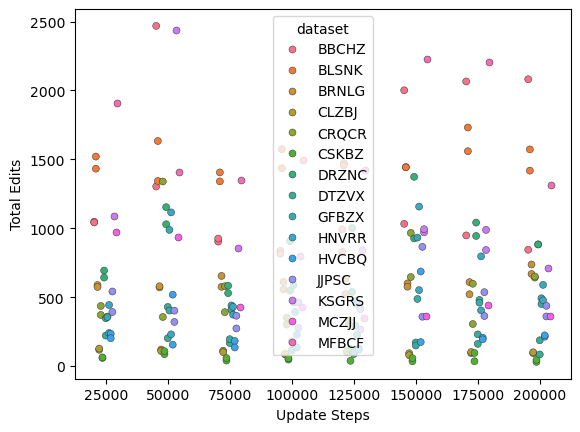

In [6]:
sns.stripplot(data=baseline, x=c["checkpoints"], y=c["skel_mods"], hue="dataset", dodge=True, jitter=0, linewidth=0.4)
plt.show()

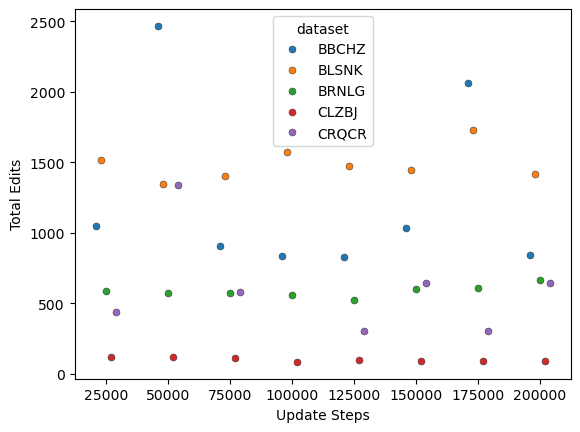

In [51]:
sns.stripplot(data=baseline, x=c["checkpoints"], y=c["skel_mods"], hue="dataset", dodge=True, jitter=0, linewidth=0.4)
plt.show()

In [7]:
def agg(group, by):
  return group.agg({
    c["skel_mods"]: by,
    c["voi_sum"]: by,
    c["nvi_sum"]: by
  })

In [14]:
min = agg(baseline.groupby(["Model Type", c["checkpoints"], "dataset"]), "min").reset_index()

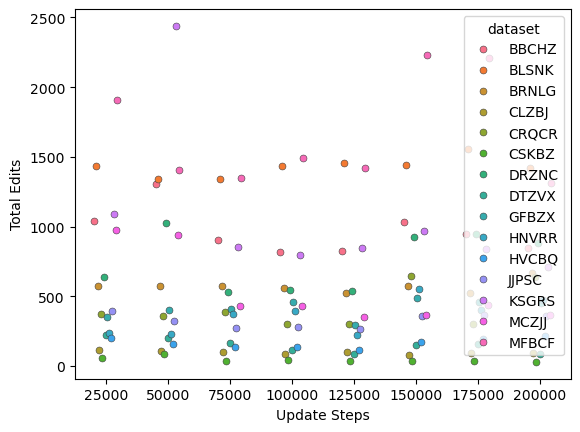

In [16]:
sns.stripplot(data=min, x=c["checkpoints"], y=c["skel_mods"], hue="dataset", dodge=True, jitter=0, linewidth=0.4)
plt.show()

In [17]:
avg = agg(baseline.groupby(["Model Type", c["checkpoints"]]), "avg").reset_index()

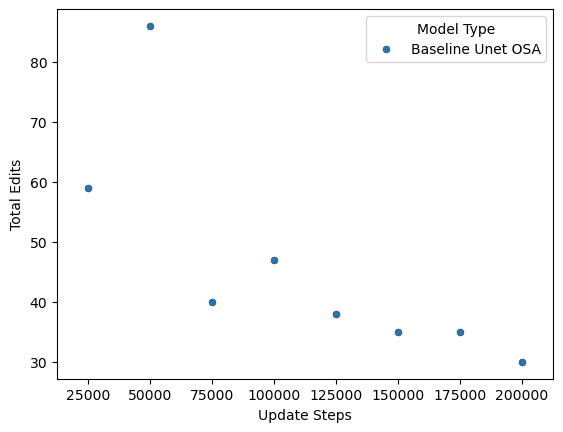

In [19]:
sns.stripplot(data=avg, x=c["checkpoints"], y=c["skel_mods"], hue="Model Type", dodge=True, jitter=0, linewidth=0.4)
plt.show()

In [85]:
masked = create_dataframe({
  "Baseline Unet OSA": ["baselines/unet/1"]#, "baselines/unet/2", "baselines/unet/3"]
}, "BBCHZ")
masked["normalized_skel_mods"] = masked["skel_mods"] / masked["total_path_length"]
masked.rename(columns=c, inplace=True)

['/home/anton/github/autoseg/src/autoseg/artifacts/UNet_OSA_run_1/results/step-75000/oblique_results.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_OSA_run_1/results/step-200000/oblique_results.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_OSA_run_1/results/step-125000/oblique_results.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_OSA_run_1/results/step-150000/oblique_results.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_OSA_run_1/results/step-25000/oblique_results.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_OSA_run_1/results/step-175000/oblique_results.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_OSA_run_1/results/step-50000/oblique_results.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_OSA_run_1/results/step-100000/oblique_results.json']
['/home/anton/github/autoseg/src/autoseg/artifacts/UNet_OSA_run_1/results/step-75000/BBCHZ_results.json', '/home/anton/github/autoseg/src/